In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from Networks.DNN import PINN
from Networks.IA_DNN import Attention_PINN
from Networks.RES_DNN import RES_PINN
from Networks.RES_IA_PINN import RES_IA_PINN
from DataGenerator import DataGenerator

In [2]:
# Define the fractal-like 2D function
def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    
    # Add noise to z
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    
    return z

current device is cuda


loss: 8.5736e-03: 100%|██████████| 50000/50000 [01:27<00:00, 568.98it/s]


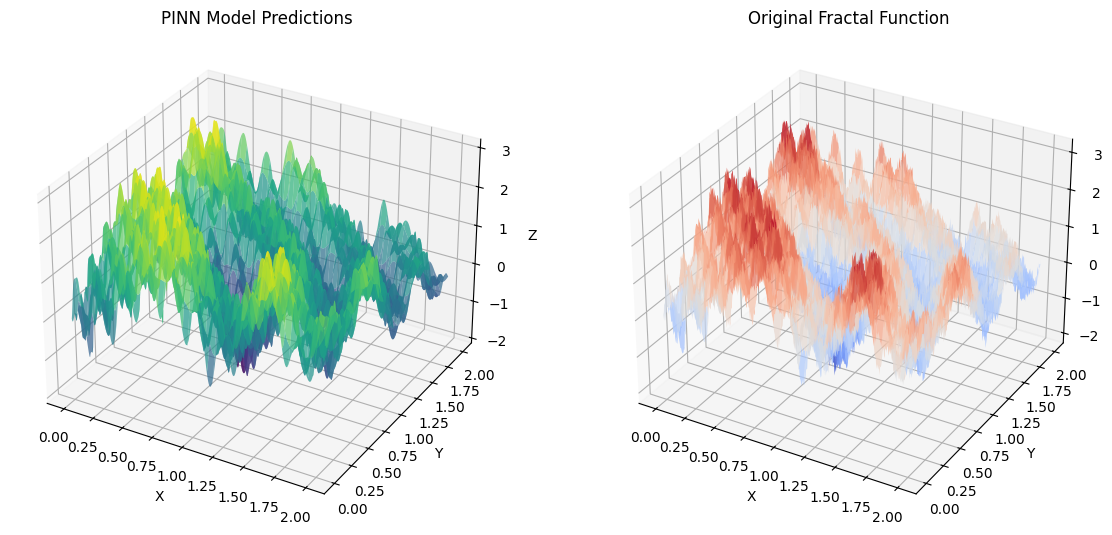

loss: 8.3246e-03: 100%|██████████| 50000/50000 [02:25<00:00, 344.21it/s]


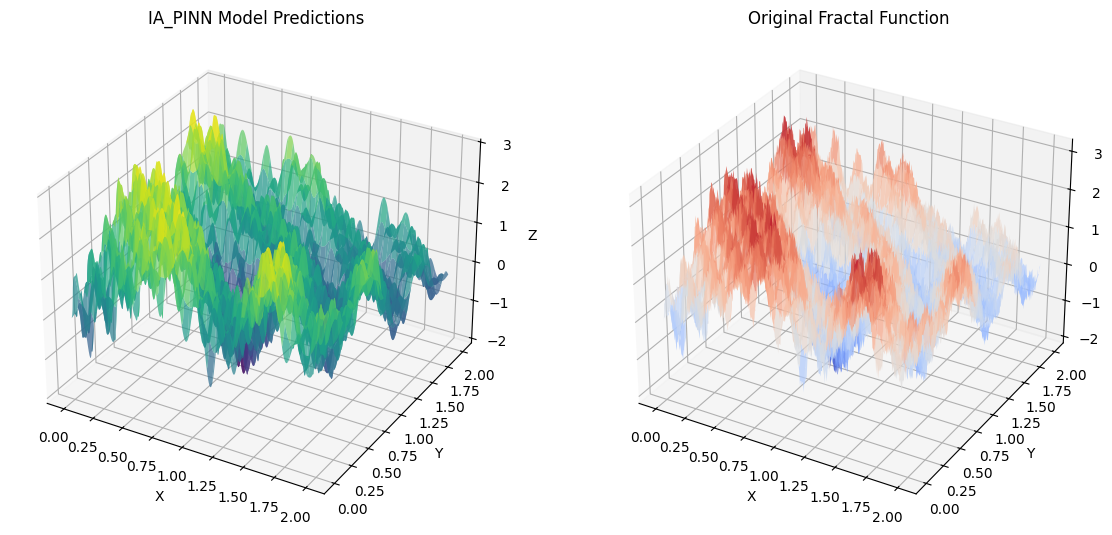

loss: 3.1379e-03: 100%|██████████| 50000/50000 [02:23<00:00, 347.68it/s]


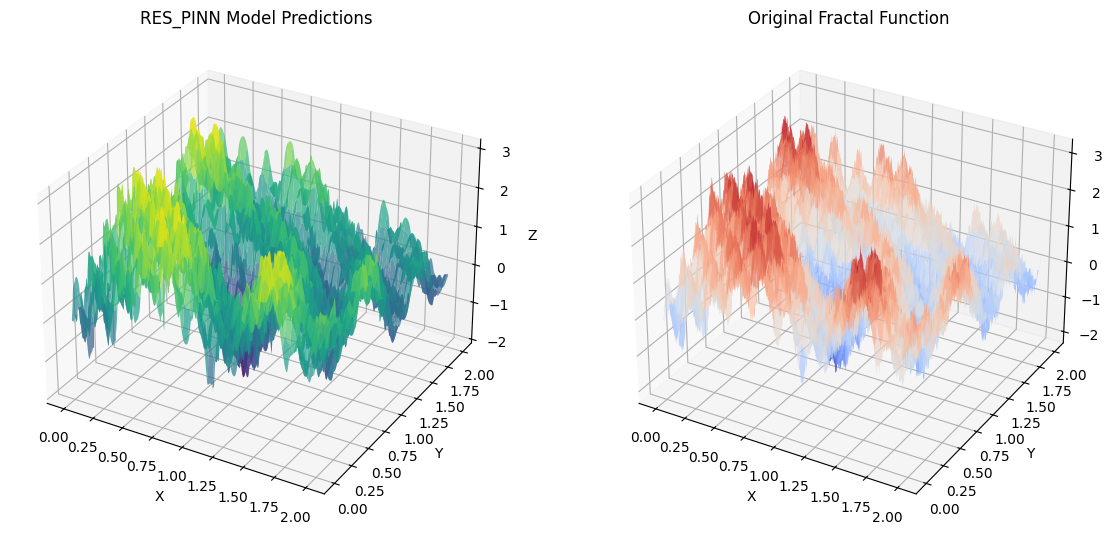

loss: 2.2206e-03: 100%|██████████| 50000/50000 [03:22<00:00, 247.08it/s]


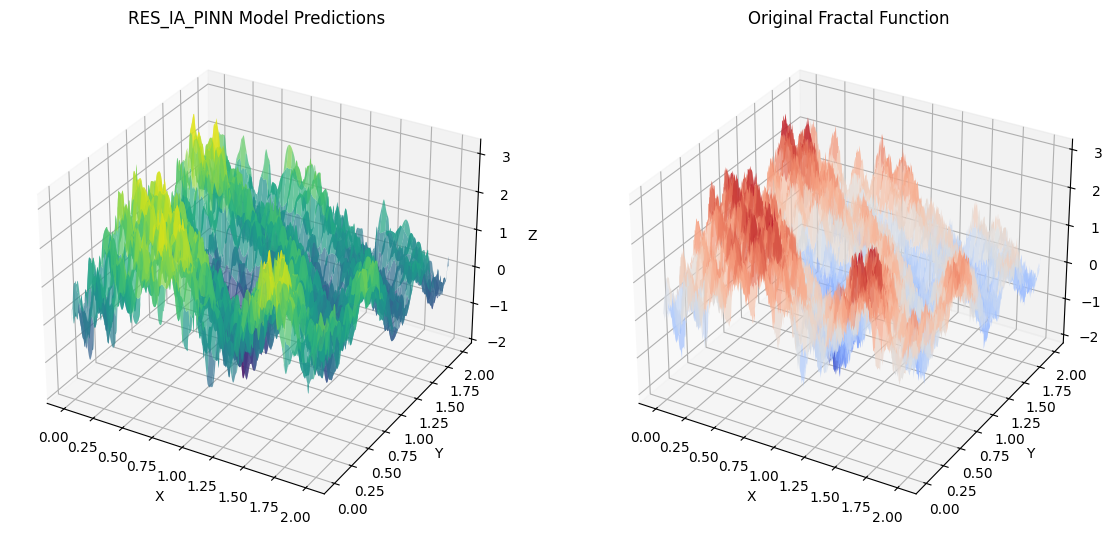

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('current device is {}'.format(device))

# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32).to(device)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1).to(device)

criterion = nn.MSELoss()
num_epochs = 50000
layer = [2] + [64]*3 + [1]


for mode in ['PINN','IA_PINN','RES_PINN','RES_IA_PINN']:
    pbar = tqdm(range(num_epochs))
    
    if mode == 'PINN':
        model = PINN(layer,non_negative=False).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-2)

    elif mode == 'IA_PINN':
        model = Attention_PINN(layer,non_negative=False).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-2)

    elif mode == 'RES_PINN':
        model = RES_PINN(layer,non_negative=False).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-2)

    elif mode == 'RES_IA_PINN':
        model = RES_IA_PINN(layer,non_negative=False).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-2)  
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-3)
    for epoch in pbar:
        optimizer.zero_grad()
        output = model(x_train_2d)
        
        loss = criterion(output, y_train_2d)
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 100 == 0:
            pbar.set_description(f'loss: {loss.item():.4e}')
    
    # Test the models
    x_test = np.linspace(0, 2, 400)
    y_test = np.linspace(0, 2, 400)
    X_test, Y_test = np.meshgrid(x_test, y_test)
    Z_test = fractal_function(X_test, Y_test)
    x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32).to(device)
    
    y_pred_mlp = model(x_test_2d).data.cpu().detach().numpy()

    fig = plt.figure(figsize=(14, 21))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X_test, Y_test, y_pred_mlp.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP Prediction')
    ax1.set_title(f'{mode} Model Predictions')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7, label='Original Function')
    ax2.set_title('Original Fractal Function')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    plt.show()